In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import argparse
import functools
import hashlib
import itertools
import json
import os
import sys
from copy import deepcopy
from functools import partial
from glob import glob
from multiprocessing import Pool
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import portalocker as pl
import seaborn as sns
from matplotlib import cm
from tqdm import tqdm
from matplotlib.lines import Line2D

from plot_metrics import preprocess_metrics
from util.metrics_utils import *
from util.colour_mapper import colour_mapper

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
img_path = '/home/giampaolo/facil-tc/hf-project/final_results/results/images/memory/'
img_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/images/memory/'

if not os.path.exists(img_path):
    os.makedirs(img_path)

In [ ]:
# def barplot_decay(data, base, incr, metric, approach, savefig=None):
#     import matplotlib as mpl
#     # https://stackoverflow.com/questions/6615002/given-an-rgb-value-how-do-i-create-a-tint-or-shade/6615053
#     # For tints, calculate (255 - previous value), 
#     # multiply that by 1/4, 1/2, 3/4, etc. (the greater the factor, the lighter the tint),
#     # and add that to the previous value (assuming each.component is a 8-bit integer).
#     def make_lighter(rgba_color, weight=0.5):
#         delta = 255 - 255 * rgba_color
#         delta = delta * weight
#         return (255 * rgba_color + delta) / 255

#     colors_top = 'lightgray'
#     colors_bottom = 'gray'
#     xticks = [base + (i + 1) * incr for i in np.arange(len(data[data['Type'] == 'New']))]
#     fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))

#     font_size = 14
#     mpl.rcParams.update({
#         'font.size': font_size,
#         'xtick.labelsize': font_size,
#         'ytick.labelsize': font_size,
#     })

#     col_idx = 0
#     #############################
#     ### TOP histo
#     #############################
#     ax = axes[0]
#     data[data['Type'] == 'Old'].plot(ax=ax, kind='bar', rot=0, color=colors_top)
#     #, width=1)#, yerr=df_lst['std_old'].values)
#     ax.xaxis.set_ticklabels(xticks)

#     ax.set_ylim(0,100)
#     ax.set_title('%s Decay: %s base: %s, incr: %s' % (metric, appr_dict[approach], base, incr))
#     ax.spines['top'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     if col_idx == 0:
#         ax.set_ylabel('avg f1 drop : old')
#     else:
#         ax.yaxis.set_ticklabels([])   
#     for p in ax.patches:
#             ax.annotate(
#                 f'{p.get_height():.2f}', 
#                (p.get_x() + p.get_width() / 2., p.get_height()-.025), 
#                ha = 'center', va = 'center', 
#                xytext = (0, 9), 
#                textcoords = 'offset points'
#             )

#     #############################
#     ### BOTTOM histo
#     #############################
#     ax = axes[1]
#     data[data['Type'] == 'New'].plot(ax=ax, kind='bar', color=colors_bottom)
#     #, width=1)#, yerr=df_lst['std_new'].values)

#     ax.set_ylim(0, 100)
#     ax.invert_yaxis()
#     ax.xaxis.set_ticks_position('top')
#     ax.xaxis.set_ticklabels([])

#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     if col_idx == 0:
#         ax.set_ylabel('avg f1 drop : new')
#     else:
#         ax.yaxis.set_ticklabels([])

#     for p in ax.patches:
#         ax.annotate(
#             f'{p.get_height():.2f}', 
#                (p.get_x() + p.get_width() / 2., p.get_height()+ 15 ), 
#                 ha = 'center', va = 'center', 
#                 xytext = (0, 9), 
#                 textcoords = 'offset points'
#             )

#     if savefig:
#         plt.savefig('%s.pdf' % savefig, bbox_inches='tight')
        
#     plt.show()
    

In [ ]:
fns = glob('/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/*memory_sens*/**/*per_class*.parquet', recursive=True)
df, scenarios = load_data(fns, return_scenarios=True)

In [ ]:
df['Approach'].unique()

In [ ]:
fns = glob('/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results_UB/**/*per_class*.parquet', recursive=True)
df_cv_scr = load_scratch_data(fns, base=20, incr=20)
df_tc_scr = load_scratch_data(fns, base=39, incr=1)

In [ ]:
df_cv=df[(df['Episode'] == 1) & (df['Base Apps'] == 20) & (df['Seed'].isin(range(1,11)))]
df_tc=df[(df['Episode'] == 1) & (df['Base Apps'] == 39)]

In [ ]:
df_cv_drp = compute_drops(df_cv, df_cv_scr)
df_tc_drp = compute_drops(df_tc, df_tc_scr)

In [ ]:
def mirrored_barplots(data, x='Memory Size', y='F1 Score Drop', hue='Approach', hue_order=None, palette=None, ci=None,
                      xlabel='Memory', ylabels=['DropOld [%]', 'DropNew [%]'], xticks=[100, 1000, 10000, 100000],
                      savefig=None):
    
    def annotate(g, size=10, yoff=0):
        for p in g.patches:
            g.annotate(format(p.get_height(), '.1f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height() + yoff), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), size=size,
                       textcoords = 'offset points')
    
    fig, axes = plt.subplots(2, 1, figsize=(8,4.3))
    
    color_dict = colour_mapper()
        
    g = sns.barplot(data=data[data['Type'] == 'Old'], x=x, y=y, hue=hue, palette=palette, hue_order=hue_order,
                    ax=axes[0], ci=ci)
    g.legend_.remove()
    
    annotate(g, size=12)
    
    g = sns.barplot(data=data[data['Type'] == 'New'], x=x, y=y, hue=hue, palette=palette, hue_order=hue_order,
                    ax=axes[1], ci=ci, alpha=.7)
    g.legend_.remove()
    
    annotate(g, size=12, yoff=18)
    
    axes[0].set_xlabel(xlabel, labelpad=-14, fontsize=14)
    axes[0].set_ylabel(ylabels[0], fontsize=14)
    axes[1].set_xlabel('')
    axes[1].set_ylabel(ylabels[1], fontsize=14)
    
    axes[0].set_xticklabels([('%s' % v)[::-1].replace('000', 'k')[::-1] for v in xticks],
                           fontsize=12)
    axes[1].set_xticklabels(['' for v in xticks])
    
    axes[0].set_yticks(range(0, 101, 25))
    axes[1].set_yticks(range(0, 101, 25))
    axes[0].set_yticklabels(range(0, 101, 25), fontsize=12)
    axes[1].set_yticklabels(range(0, 101, 25), fontsize=12)
    
    axes[0].set_ylim(0, 100)
    axes[1].set_ylim(0, 100)
    
    axes[1].invert_yaxis()
    
    axes[0].grid(False)
    axes[1].grid(False)
    
    leg = axes[0].legend(fontsize=12)
    leg.get_frame().set_linewidth(0.0)
    
    if savefig:
#         plt.tight_layout()
        plt.savefig('%s.pdf' % savefig, bbox_inches='tight')
    
    plt.show()

In [ ]:
memories = [100, 1000, 10000, 100000]
approaches = [appr_dict[k] for k in ['scratchmem', 'scratchmembal', 'bic']]
# approaches = [appr_dict[k] for k in ['scratchmem', 'scratchmembal', 'jointmembal', 'bic']]
color_dict = colour_mapper()
palette = dict([(appr_dict[k], color_dict[k]) for k in color_dict])

for tmp_df, scenario in zip([df_cv_drp, df_tc_drp], ['cv', 'tc']):
    filt = (tmp_df['Memory Size'].isin(memories)) & (tmp_df['Approach'].isin(approaches))    
    mirrored_barplots(tmp_df[filt], hue_order=approaches, palette=palette, xticks=memories, ci=None,
                      savefig=os.path.join(img_path, 'memory_sensitivity_%s' % scenario))

In [114]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [115]:
df=pd.read_parquet('mem_embedded_39_0_7_1674381104649727.parquet')

ext_df = pd.DataFrame(df[['x','y','label']], columns=['x','y','label'])
ext_df['type'] = 'all'
for sel in ['random', 'herding', 'entropy', 'distance', 'ensemble']:
    ext_df = pd.concat((ext_df, pd.DataFrame(df.loc[df[sel],['x','y','label']], columns=['x','y','label','type'])))
    ext_df.loc[ext_df['type'].isna(), 'type'] = sel

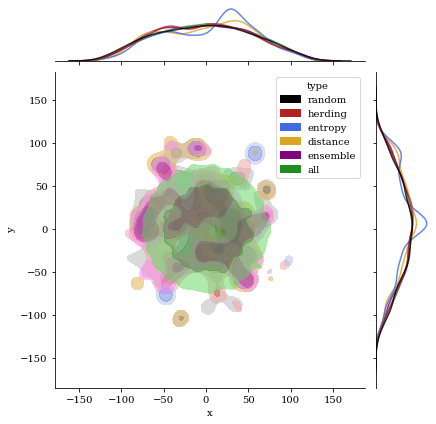

0


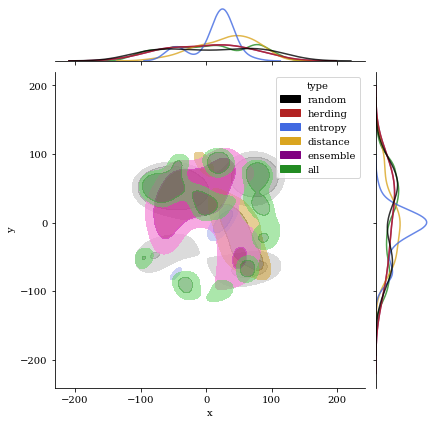

1


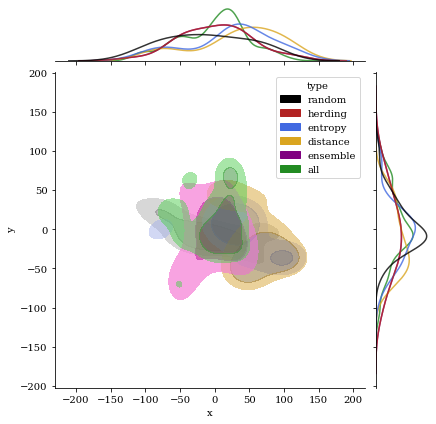

2


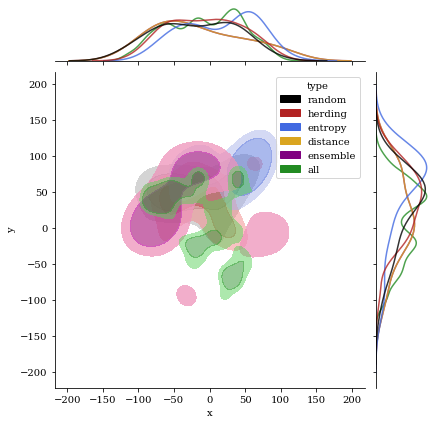

3


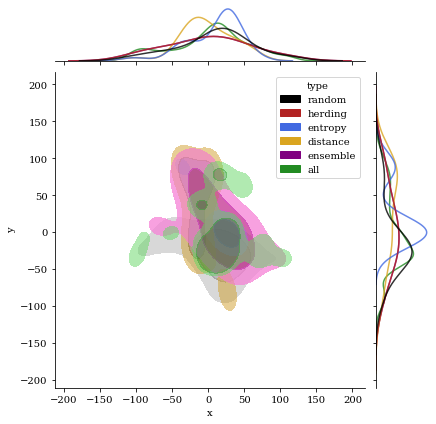

4


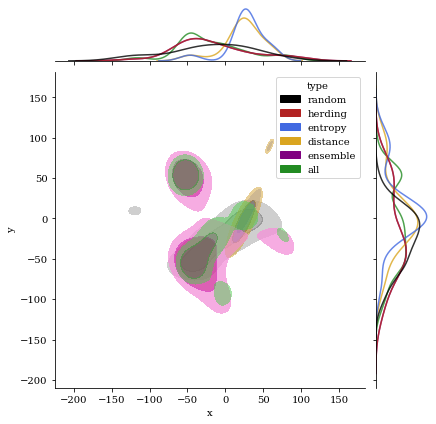

5


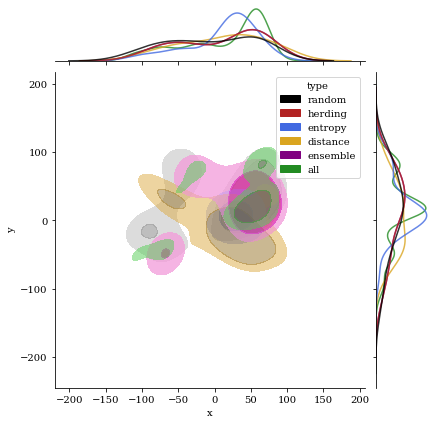

6


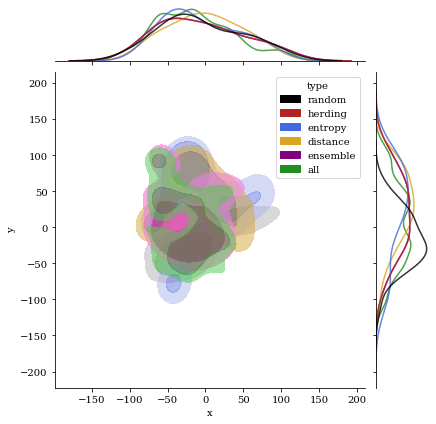

7


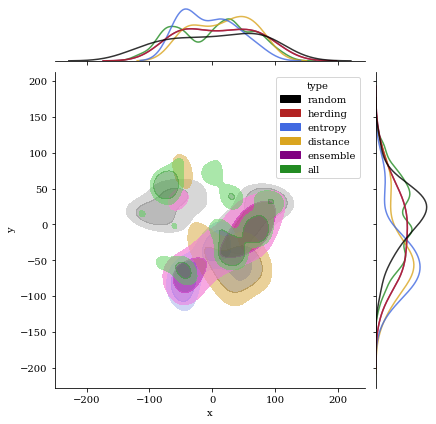

8


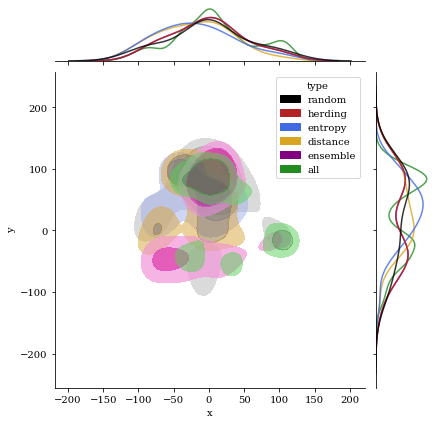

9


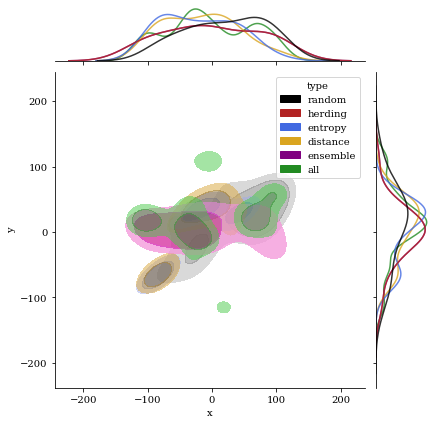

10


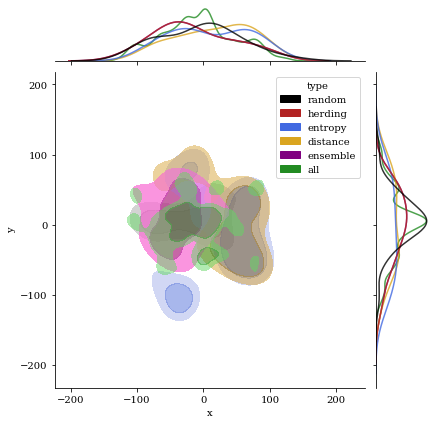

11


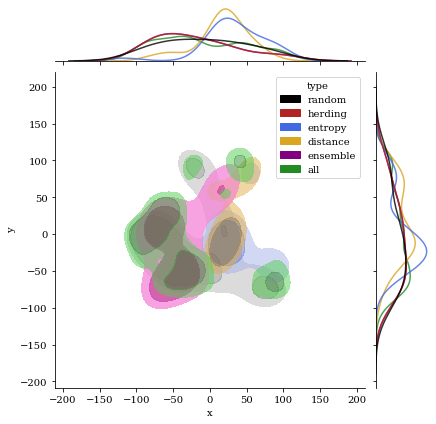

12


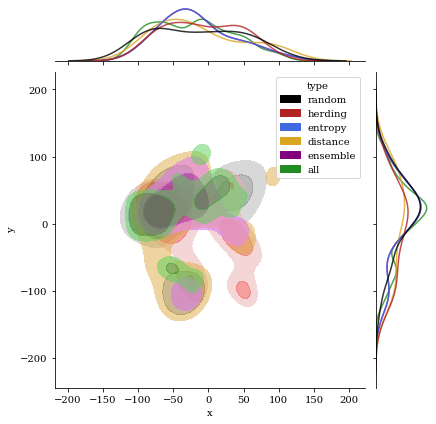

13


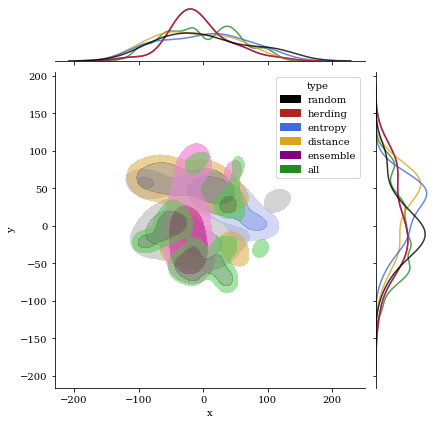

14


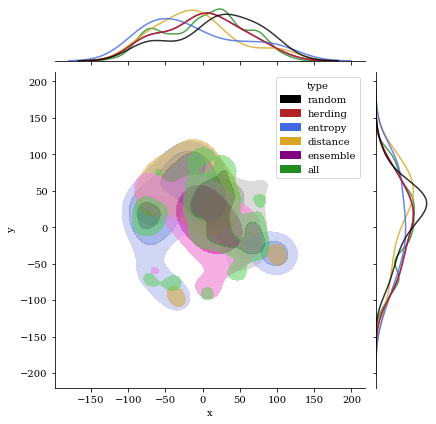

15


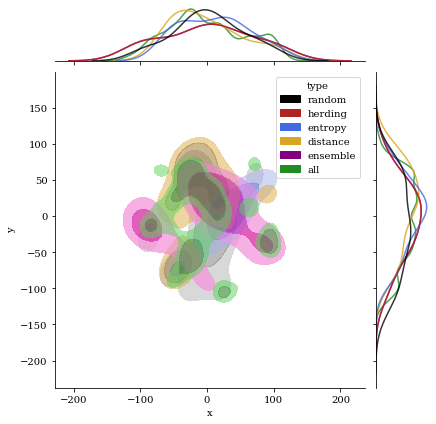

16


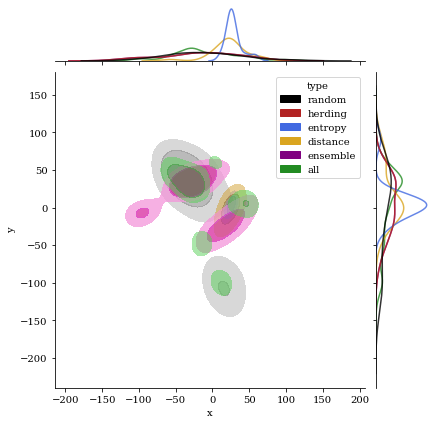

17


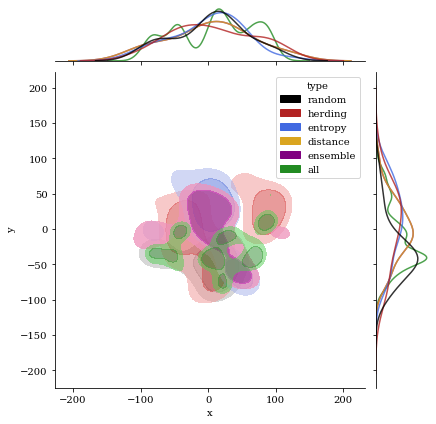

18


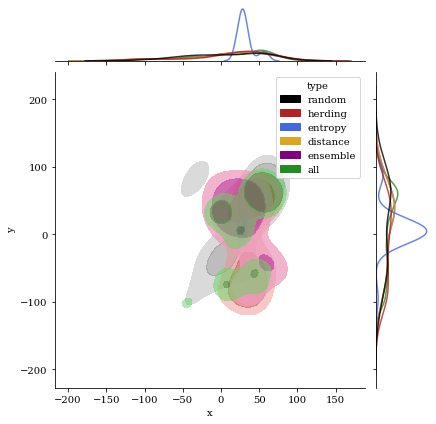

19


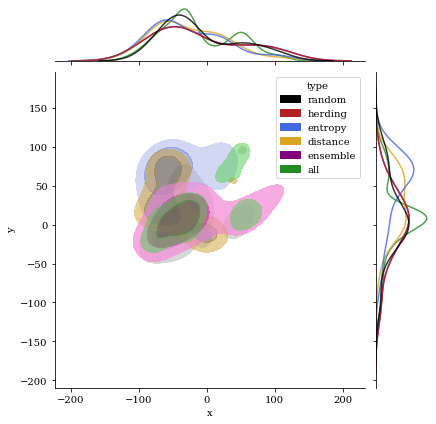

20


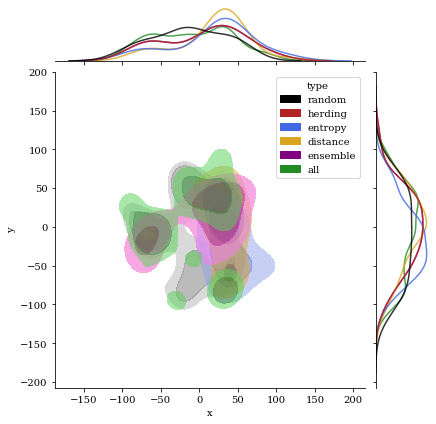

21


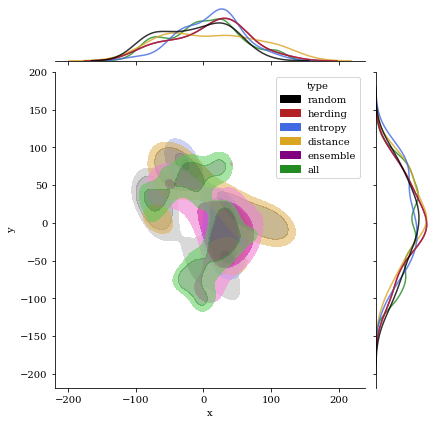

22


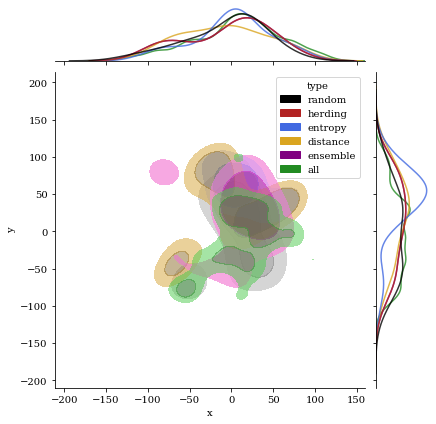

23


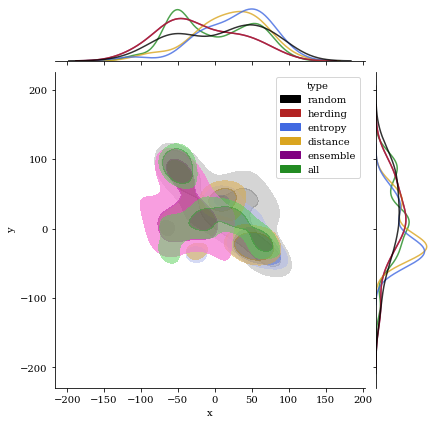

24


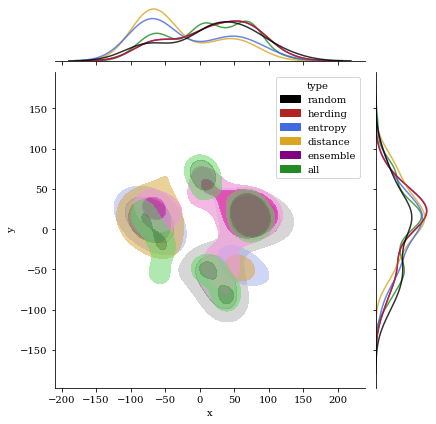

25


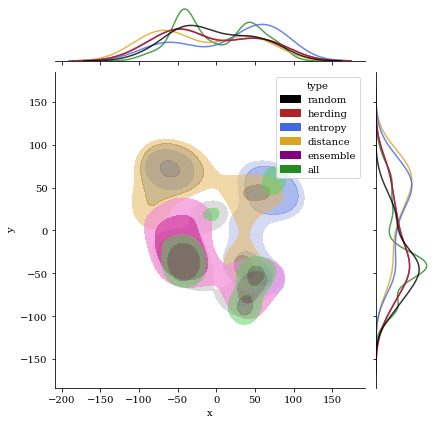

26


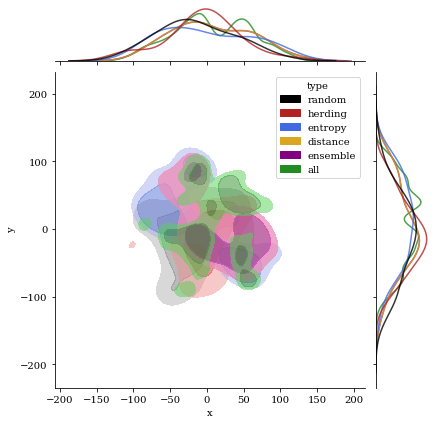

27


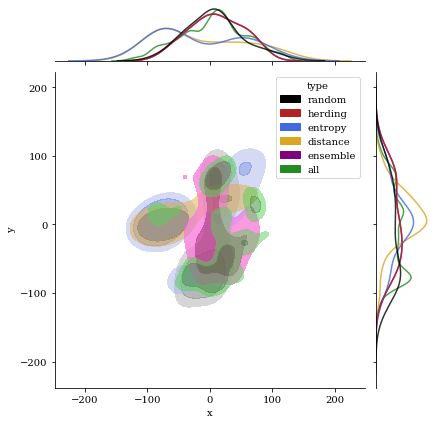

28


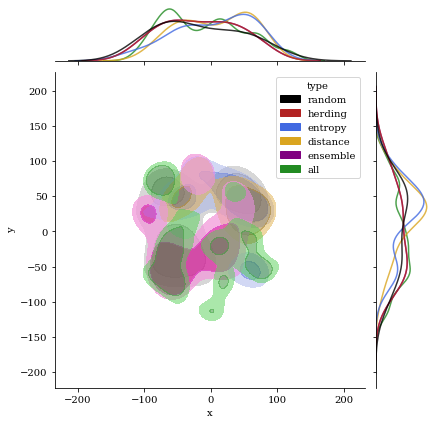

29


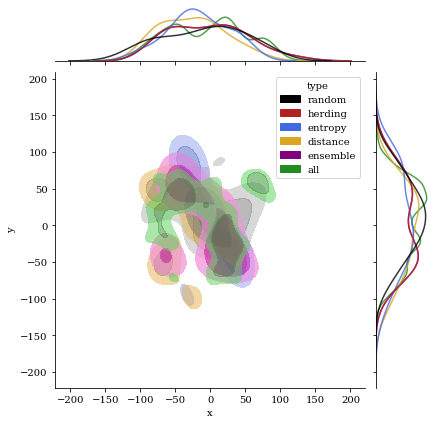

30


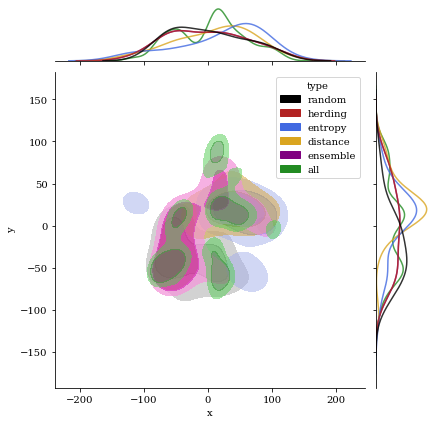

31


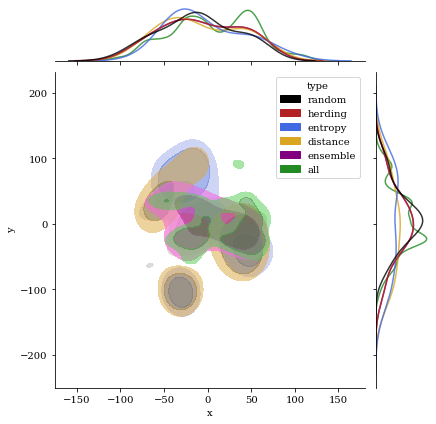

32


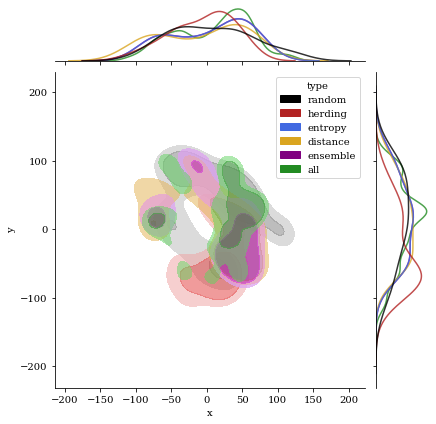

33


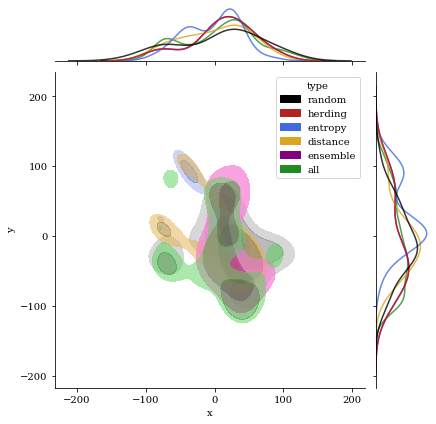

34


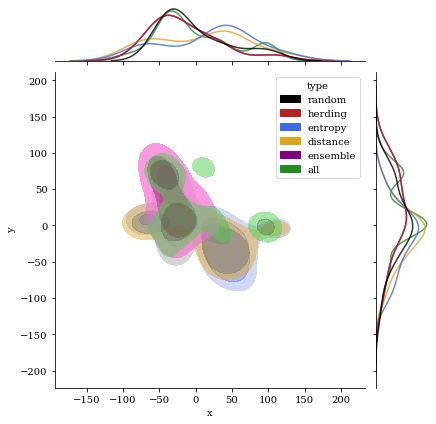

35


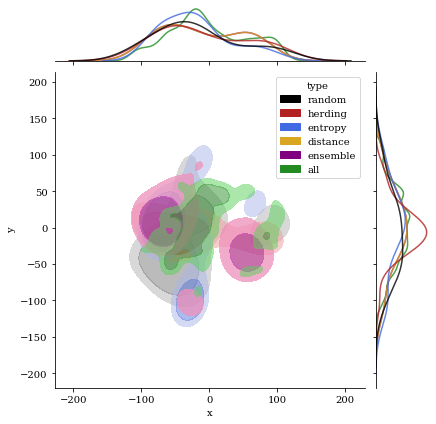

36


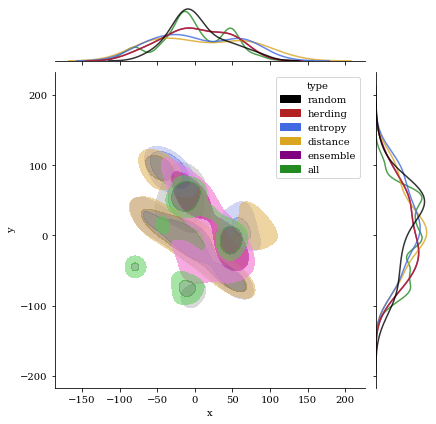

37


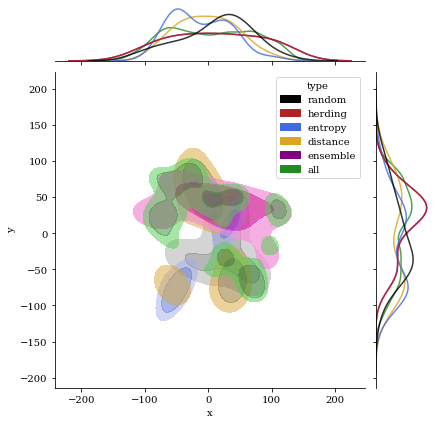

38


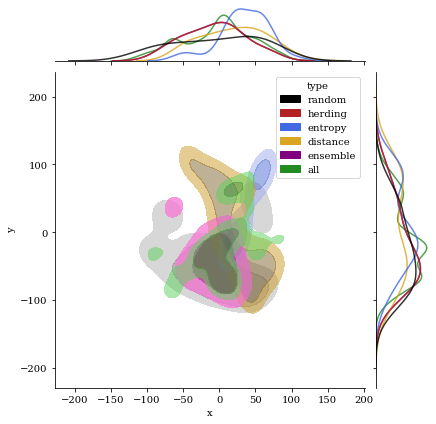

In [116]:
ax = sns.jointplot(data=ext_df, x='x', y='y', hue='type', kind='kde',
                 hue_order=['random', 'herding', 'entropy', 'distance', 'ensemble', 'all'],
            levels=3, thresh=.5, common_norm=False, bw_adjust=.5, fill=True, 
            palette=['black','firebrick','royalblue','goldenrod','purple','forestgreen'], alpha=.5,
                   marginal_kws=dict(common_norm=False, alpha=.8, fill=False, thresh=.5, bw_adjust=.5)
                  )
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

labels = np.unique(ext_df['label'].values)
for label in labels:
    print(label)
#     print(sum(ext_df['label']==label))
#     for sel in ['random', 'herding', 'entropy', 'distance']:
#         print(sel)
#         print(sum((ext_df['label']==label) & (ext_df['type']==sel)))
    ax = sns.jointplot(data=ext_df[ext_df['label']==label], x='x', y='y', hue='type', kind='kde',
                     hue_order=['random', 'herding', 'entropy', 'distance', 'ensemble', 'all'],
                levels=3, thresh=.5, common_norm=False, bw_adjust=.8, fill=True, 
                palette=['black','firebrick','royalblue','goldenrod','purple','forestgreen'], alpha=.5,
                       marginal_kws=dict(common_norm=False, alpha=.8, fill=False)
                      )
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()
    

In [117]:
for label in labels:
    print(label)
    x=df.loc[df['label']==label, 'x'].values
    y=df.loc[df['label']==label, 'y'].values
    x_perc = np.percentile(x,range(101))
    y_perc = np.percentile(y,range(101))
    dists = []
    for sel in ['random', 'herding', 'entropy', 'distance', 'ensemble']:
        x_sel=df.loc[(df['label']==label) & (df[sel]), 'x'].values
        y_sel=df.loc[(df['label']==label) & (df[sel]), 'y'].values
        x_sel_perc = np.percentile(x_sel,range(101))
        y_sel_perc = np.percentile(y_sel,range(101))
#         dist = np.mean([np.mean((x_perc-x_sel_perc)**2), np.mean((y_perc-y_sel_perc)**2)])
        dist = np.mean([(x_perc-x_sel_perc)**2, (y_perc-y_sel_perc)**2])
        dists.append(dist)
        print(sel, dist)

0
random 182.06874553011397
herding 100.49222687551105
entropy 1928.400215739749
distance 1045.448248536338
ensemble 100.49222687551105
1
random 390.156856089089
herding 119.08400239965704
entropy 651.0488743247292
distance 1077.7565234773276
ensemble 119.08400239965704
2
random 370.19940499519896
herding 514.6632056757682
entropy 1600.1844120234418
distance 232.29323967596991
ensemble 232.29323967596991
3
random 241.4240200963848
herding 62.523947826121095
entropy 988.6650970334557
distance 894.4159032267105
ensemble 62.523947826121095
4
random 498.92629095158696
herding 105.1551870340646
entropy 2004.9080421596798
distance 1456.0925633213806
ensemble 105.1551870340646
5
random 294.32480274603154
herding 92.26384945215885
entropy 529.6719679461465
distance 283.3184428467289
ensemble 92.26384945215885
6
random 510.42478726666036
herding 264.96040358633644
entropy 414.19759333511996
distance 576.7668554896483
ensemble 264.96040358633644
7
random 306.06129667028137
herding 230.2291036126

In [118]:
for label in labels:
    for sel in ['random', 'herding', 'entropy', 'distance', 'ensemble']:
        print(label,sel,sum(df.loc[df['label']==label,sel]))

0 random 26
0 herding 26
0 entropy 26
0 distance 26
0 ensemble 26
1 random 26
1 herding 26
1 entropy 26
1 distance 26
1 ensemble 26
2 random 26
2 herding 26
2 entropy 26
2 distance 26
2 ensemble 26
3 random 26
3 herding 26
3 entropy 26
3 distance 26
3 ensemble 26
4 random 26
4 herding 26
4 entropy 26
4 distance 26
4 ensemble 26
5 random 26
5 herding 26
5 entropy 26
5 distance 26
5 ensemble 26
6 random 26
6 herding 26
6 entropy 26
6 distance 26
6 ensemble 26
7 random 26
7 herding 26
7 entropy 26
7 distance 26
7 ensemble 26
8 random 26
8 herding 26
8 entropy 26
8 distance 26
8 ensemble 26
9 random 26
9 herding 26
9 entropy 26
9 distance 26
9 ensemble 26
10 random 26
10 herding 26
10 entropy 26
10 distance 26
10 ensemble 26
11 random 26
11 herding 26
11 entropy 26
11 distance 26
11 ensemble 26
12 random 26
12 herding 26
12 entropy 26
12 distance 26
12 ensemble 26
13 random 26
13 herding 26
13 entropy 26
13 distance 26
13 ensemble 26
14 random 26
14 herding 26
14 entropy 26
14 distance 26


In [45]:
for sel in ['random', 'herding', 'entropy', 'distance']:
    print(sel, '\n', df.loc[df[sel], ['x', 'y']].mean(), '\n', df.loc[df[sel], ['x', 'y']].std(), '\n')

random 
 x   -3.051491
y   -3.056352
dtype: float32 
 x    55.913338
y    55.852348
dtype: float32 

herding 
 x    0.307890
y   -0.421244
dtype: float32 
 x    54.545624
y    54.545216
dtype: float32 

entropy 
 x   -3.025067
y    3.167404
dtype: float32 
 x    54.515854
y    55.871822
dtype: float32 

distance 
 x    2.096084
y   -0.384376
dtype: float32 
 x    55.231541
y    55.654572
dtype: float32 



In [4]:
df = pd.read_parquet('/media/nas/datasets/MIRAGE_2020/modeling_and_prediction/datasets/class_incremental/dataset_100pkt_5f_payload_df_exact_noNullver_no0load_noMaps_pseudolabels_nodegclust_b8829cf2.parquet')

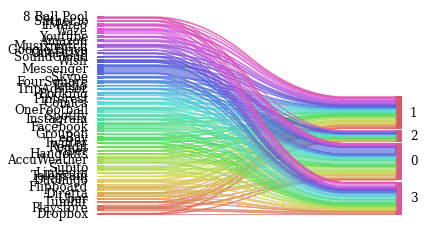

In [23]:
from pysankey import sankey

sankey(df['LABEL'], df['PSEUDO_LABEL'], aspect=20, fontsize=12)

plt.show()